## Imports

In [1]:
import os
import math
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from read_data import *

## Set Styles for transfer

In [2]:
styles = {
    0 : 'Gorodets',
    1 : 'Gzhel',
    2 : 'Iznik',
    3 : 'Khokhloma',
    4 : 'Neglyubka',
    5 : 'Wycinanki_Å‚owickie',
    6 : 'Wzory_kaszubskie'
}

style_X = styles[1]
style_Y = styles[4]

## Set saving / restoring

In [3]:
restoring_mode = False
saving_mode = False

restoring_name = 'first_model.ckpt'
saving_name = 'first_model.ckpt'

restoring_path = os.path.join('models', style_X + ' =|= ' + style_Y, restoring_name)
saving_path = os.path.join('models', style_X + ' =|= ' + style_Y, saving_name)

## Adjust Hyperparameters

In [4]:
EPOCHS = 100
BATCH_SIZE = 8
IMG_SIZE = 150

LAMBDA = 0
GEN_STEPS = 25
DSC_STEPS = 10

## Neural Network functions

### Convolution Layers

In [5]:
def conv_layer(X, filters, filter_size, stride, name, collection, activation=None):
    """Create a new convolution layer with Xavier initializer"""
    
    with tf.variable_scope(name):
        
        # create Xavier initializer node 
        in_channels = int(X.get_shape()[3])
        init = tf.contrib.layers.xavier_initializer_conv2d()
    
        # create the parameter structures         
        W = tf.get_variable(initializer=init, 
                            shape=(filter_size[0], filter_size[1],
                                   in_channels, filters),
                            name="weights")
        b = tf.get_variable(initializer=tf.zeros(filters),
                            name="biases")
        
        # add parameters to the collection
        tf.add_to_collection(collection, W)
        tf.add_to_collection(collection, b)
        
        # perform convolution and add bias
        conv = tf.nn.conv2d(X, W, strides=(1, stride, stride, 1), padding="SAME")
        z = tf.nn.bias_add(conv, b)
        
        # activation function
        if activation == "relu":
            return tf.nn.relu(z)
        elif activation == "sigmoid":
            return tf.nn.sigmoid(z)
        elif activation == "tanh":
            return tf.nn.tanh(z)
        else:
            return z
     

def deconv_layer(X, filters, filter_size, stride, output_shape, name, collection, activation=None):
    """Create a new deconvolution layer with Xavier initializer"""

    with tf.variable_scope(name):

        # create Xavier initializer node 
        in_channels = int(X.get_shape()[3])
        init = tf.contrib.layers.xavier_initializer_conv2d()

        # create the parameter structures         
        W = tf.get_variable(initializer=init,
                            shape=(filter_size[0], filter_size[1],
                                   filters, in_channels),
                            name="weights")
        b = tf.get_variable(initializer=tf.zeros(filters),
                            name="biases")
                
        # add parameters to the collection
        tf.add_to_collection(collection, W)
        tf.add_to_collection(collection, b)
        
        # perform convolution and add bias
        conv = tf.nn.conv2d_transpose(X, W, output_shape=output_shape,
                                      strides=(1, stride, stride, 1), padding="SAME")
        z = tf.nn.bias_add(conv, b)

        # activation function
        if activation == "relu":
            return tf.nn.relu(z)
        else:
            return z
        
        
def residual_layer(X, filter_size, stride, name, collection, activation=None):
    """Create a new residual convolution layer with Xavier initializer"""
    
    # get number of input filters     
    filters = in_channels = int(X.get_shape()[3])
    
    # add residuals to convolution     
    z = X + conv_layer(X, filters, filter_size, stride, name, collection)

    # activation function
    if activation == "relu":
        return tf.nn.relu(z)
    else:
        return z

## Build the model and deploy it on a device

In [6]:
with tf.device('/cpu:0'):
    
    #==================[ READ AND PROCESS THE INPUT ]==================#
            
    # load training data from input queues     
    X = inputs(style_X, BATCH_SIZE, EPOCHS)
    Y = inputs(style_Y, BATCH_SIZE, EPOCHS)
    
    # normalize the images     
    X = tf.subtract(tf.div(tf.cast(X, tf.float32), 127.5), 1)
    Y = tf.subtract(tf.div(tf.cast(Y, tf.float32), 127.5), 1)

### Generators

In [7]:
with tf.device('/gpu:0'):
    
    #==================[ G(X) -> Y ]==================#
    
    X_conv_1 = conv_layer(X, 32, (9, 9), 1, "X_conv_1", "GEN", "relu")
    X_conv_2 = conv_layer(X_conv_1, 64, (3, 3), 2, "X_conv_2", "GEN", "relu")
    X_conv_3 = conv_layer(X_conv_2, 128, (3, 3), 2, "X_conv_3", "GEN", "relu")
    
    X_res_1 = residual_layer(X_conv_3, (1, 1), 1, "X_res_1", "GEN", "relu")
    X_res_2 = residual_layer(X_res_1, (1, 1), 1, "X_res_2", "GEN", "relu")
    X_res_3 = residual_layer(X_res_2, (1, 1), 1, "X_res_3", "GEN", "relu")
    
    X_deconv_2 = deconv_layer(X_res_3, 64, (3, 3), 2, [BATCH_SIZE, 75, 75, 64], "X_deconv_2", "GEN", "relu")
    X_deconv_1 = deconv_layer(X_deconv_2, 32, (3, 3), 2, [BATCH_SIZE, 150, 150, 32], "X_deconv_1", "GEN", "relu")
    G_x = deconv_layer(X_deconv_1, 3, (9, 9), 1, [BATCH_SIZE, 150, 150, 3], "G_x", "GEN", "tanh")
    
    #==================[ F(Y) -> X ]==================#
    
    Y_conv_1 = conv_layer(Y, 32, (9, 9), 1, "Y_conv_1", "GEN", "relu")
    Y_conv_2 = conv_layer(Y_conv_1, 64, (3, 3), 2, "Y_conv_2", "GEN", "relu")
    Y_conv_3 = conv_layer(Y_conv_2, 128, (3, 3), 2, "Y_conv_3", "GEN", "relu")
    
    Y_res_1 = residual_layer(Y_conv_3, (1, 1), 1, "Y_res_1", "GEN", "relu")
    Y_res_2 = residual_layer(Y_res_1, (1, 1), 1, "Y_res_2", "GEN", "relu")
    Y_res_3 = residual_layer(Y_res_2, (1, 1), 1, "Y_res_3", "GEN", "relu")
    
    Y_deconv_2 = deconv_layer(Y_res_3, 64, (3, 3), 2, [BATCH_SIZE, 75, 75, 64], "Y_deconv_2", "GEN", "relu")
    Y_deconv_1 = deconv_layer(Y_deconv_2, 32, (3, 3), 2, [BATCH_SIZE, 150, 150, 32], "Y_deconv_1", "GEN", "relu") 
    F_y = deconv_layer(Y_deconv_1, 3, (9, 9), 1, [BATCH_SIZE, 150, 150, 3], "F_y", "GEN", "tanh")
        

### Discriminators

In [8]:
with tf.device('/gpu:0'):
    
    #==================[ Dy ]==================#
    
    Dy_input = tf.concat([G_x, Y], 0)
    Dy_labels = tf.constant(BATCH_SIZE * [0] + BATCH_SIZE * [1], dtype=tf.float32)
    
    Dy_conv_1 = conv_layer(Dy_input, 32, (3, 3), 1, "Dy_conv_1", "DSC", "relu")
    Dy_conv_2 = conv_layer(Dy_conv_1, 32, (3, 3), 1, "Dy_conv_2", "DSC", "relu")
    Dy_conv_3 = conv_layer(Dy_conv_2, 1, (5, 5), 5, "Dy_conv_3", "DSC", "sigmoid")
    Dy = tf.reduce_mean(tf.contrib.layers.flatten(Dy_conv_3), -1, keep_dims=False, name="Dy")
    
    #==================[ Dx ]==================#
    
    Dx_input = tf.concat([F_y, X], 0)
    Dx_labels = tf.constant(BATCH_SIZE * [0] + BATCH_SIZE * [1], dtype=tf.float32)
    
    Dx_conv_1 = conv_layer(Dx_input, 32, (3, 3), 1, "Dx_conv_1", "DSC", "relu")
    Dx_conv_2 = conv_layer(Dx_conv_1, 32, (3, 3), 1, "Dx_conv_2", "DSC", "relu")
    Dx_conv_3 = conv_layer(Dx_conv_2, 1, (5, 5), 5, "Dx_conv_3", "DSC", "sigmoid")
    Dx = tf.reduce_mean(tf.contrib.layers.flatten(Dx_conv_3), -1, keep_dims=False, name="Dx")
    

## Losses

In [9]:
with tf.device('/gpu:0'):
    
    #==================[ Adversarial Loss ]==================#
    
    L_GAN_X = - tf.nn.sigmoid_cross_entropy_with_logits(labels=Dy_labels,
                                                        logits=Dy)
    L_GAN_Y = - tf.nn.sigmoid_cross_entropy_with_logits(labels=Dx_labels,
                                                        logits=Dx)
    
    #==================[ Consistency Loss ]==================#
    
    L_CYC = tf.constant(0.0)
    
    #=====================[ Final Loss ]=====================#
    
    Loss = tf.reduce_mean(L_GAN_X) + tf.reduce_mean(L_GAN_Y)
    

## Optimization

In [10]:
with tf.device('/gpu:0'):
    
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
    generators_op = optimizer.minimize(Loss, var_list=tf.get_collection("GEN"))
    discriminators_op = optimizer.minimize(-Loss, var_list=tf.get_collection("DSC"))

## Create the session and start the threads for input queues

In [11]:
# create the session saver
saver = tf.train.Saver()

# create a session for running operations in the graph.
sess = tf.Session()

# create the variable initializers
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# initialize the variables
sess.run(init_op)

if restoring_mode:
    # previously saved model is restored
    saver.restore(sess, restoring_path)
    
# start input enqueue threads.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

## Training loop

Step     1 | Generator         0 | loss = -1.460
Step     1 | Generator         1 | loss = -1.347
Step     1 | Generator         2 | loss = -1.460
Step     1 | Generator         3 | loss = -1.460
Step     1 | Generator         4 | loss = -1.461
Step     1 | Generator         5 | loss = -1.461
Step     1 | Generator         6 | loss = -1.461
Step     1 | Generator         7 | loss = -1.461
Step     1 | Generator         8 | loss = -1.460
Step     1 | Generator         9 | loss = -1.461
Step     1 | Generator        10 | loss = -1.461
Step     1 | Generator        11 | loss = -1.460
Step     1 | Generator        12 | loss = -1.461
Step     1 | Generator        13 | loss = -1.461
Step     1 | Generator        14 | loss = -1.461
Step     1 | Generator        15 | loss = -1.463
Step     1 | Generator        16 | loss = -1.462
Step     1 | Generator        17 | loss = -1.460
Step     1 | Generator        18 | loss = -1.461
Step     1 | Generator        19 | loss = -1.461
Step     1 | Generat

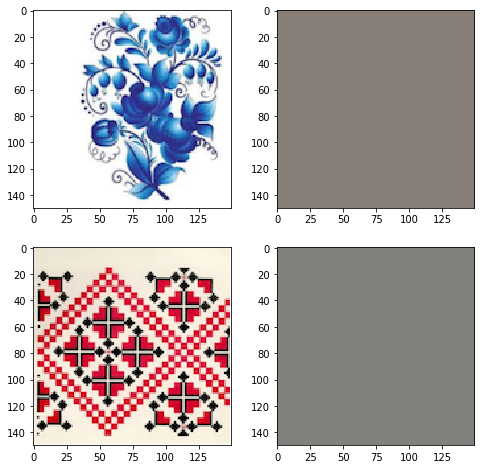

Step     2 | Generator         0 | loss = -1.046
Step     2 | Generator         1 | loss = -1.049
Step     2 | Generator         2 | loss = -1.055
Step     2 | Generator         3 | loss = -1.065
Step     2 | Generator         4 | loss = -1.087
Step     2 | Generator         5 | loss = -1.163
Step     2 | Generator         6 | loss = -1.252
Step     2 | Generator         7 | loss = -1.298
Step     2 | Generator         8 | loss = -1.311
Step     2 | Generator         9 | loss = -1.315
Step     2 | Generator        10 | loss = -1.316
Step     2 | Generator        11 | loss = -1.316
Step     2 | Generator        12 | loss = -1.316
Step     2 | Generator        13 | loss = -1.316
Step     2 | Generator        14 | loss = -1.317
Step     2 | Generator        15 | loss = -1.316
Step     2 | Generator        16 | loss = -1.316
Step     2 | Generator        17 | loss = -1.317
Step     2 | Generator        18 | loss = -1.316
Step     2 | Generator        19 | loss = -1.316
Step     2 | Generat

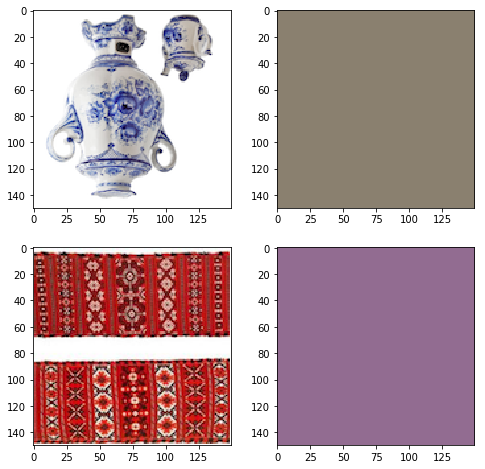

Step     3 | Generator         0 | loss = -1.316
Step     3 | Generator         1 | loss = -1.316
Step     3 | Generator         2 | loss = -1.316
Step     3 | Generator         3 | loss = -1.316
Step     3 | Generator         4 | loss = -1.317
Step     3 | Generator         5 | loss = -1.316
Step     3 | Generator         6 | loss = -1.316
Step     3 | Generator         7 | loss = -1.317
Step     3 | Generator         8 | loss = -1.316
Step     3 | Generator         9 | loss = -1.317
Step     3 | Generator        10 | loss = -1.317
Step     3 | Generator        11 | loss = -1.317
Step     3 | Generator        12 | loss = -1.316
Step     3 | Generator        13 | loss = -1.317
Step     3 | Generator        14 | loss = -1.316
Step     3 | Generator        15 | loss = -1.317
Step     3 | Generator        16 | loss = -1.317
Step     3 | Generator        17 | loss = -1.316
Step     3 | Generator        18 | loss = -1.316
Step     3 | Generator        19 | loss = -1.316
Step     3 | Generat

KeyboardInterrupt: 

In [12]:
try:
    step = 0   
    # feed data until the epoch limit is reached     
    while not coord.should_stop():
        step += 1
        
        # train the generators
        for i in range(GEN_STEPS):
            _, loss = sess.run([generators_op, Loss])
            print("Step {0:5d} | Generator     {1:5d} | loss = {2:6.3f}".format(
                    step, i, loss))
                        
        # train the discriminators
        for i in range(DSC_STEPS):
            _, loss = sess.run([discriminators_op, Loss])
            print("Step {0:5d} | Discriminator {1:5d} | loss = {2:6.3f}".format(
                    step, i, loss))

        x, f_y, y, g_x = sess.run([X, F_y, Y, G_x])
        fig=plt.figure(figsize=(8, 8))
        fig.add_subplot(2, 2, 1)
        plt.imshow((x[0, :, :, :3] + 1) / 2)
        fig.add_subplot(2, 2, 2)
        plt.imshow((f_y[0, :, :, :3] + 1) / 2)
        fig.add_subplot(2, 2, 3)
        plt.imshow((y[0, :, :, :3] + 1) / 2)
        fig.add_subplot(2, 2, 4)
        plt.imshow((g_x[0, :, :, :3] + 1) / 2)
        plt.show()
        
        
        
#         x, g_x, y, f_y, dy, dy_labels = sess.run([X, G_x, Y, F_y, Dy, Dy_labels])
#         print(dy)
#         print(dy_labels)
#         fig=plt.figure(figsize=(8, 8))
#         fig.add_subplot(2, 2, 1)
#         plt.imshow(x[0, :, :, :3])
#         fig.add_subplot(2, 2, 2)
#         plt.imshow(g_x[0, :, :, :3])
#         fig.add_subplot(2, 2, 3)
#         plt.imshow(y[0, :, :, :3])
#         fig.add_subplot(2, 2, 4)
#         plt.imshow(f_y[0, :, :, :3])
#         plt.show()
        
        
except tf.errors.OutOfRangeError:
    
    print('\nDone training -- epoch limit reached\n')
    
finally:
    
    # when done, ask the threads to stop
    coord.request_stop()

    # wait for threads to finish
    coord.join(threads)
    sess.close()